### Evaluation metrics

#### Accuracy

The robot was trained using keyboard inputs where the data was not split into train/test sets (as it would result in undesirable behaviour). So our 'y_train' is the keyboard inputs issued during training and y_pred_train is the predicted actions based on those inputs.

In [1]:
from sklearn.metrics import accuracy_score
import pandas as pd
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# create a mapping for the input values to integers 0, 1, 2, and 3
# note: the inclusion/exclusion of 'S' does not make a difference as the robot was never trained to reverse so datapoints corresponding to that input would be present
input_to_int = {
    65: 0,  # 'A'
    68: 1,  # 'D'
    87: 2,  # 'W'
    # 83: 3   # 'S'
}

data_folder = "../data/model"
joblib_filenames = [] # initialize an empty list for storing the joblib filenames

for filename in os.listdir(data_folder):
    if filename.endswith('.joblib'):
        # extract the "name" from the joblib filename (have two joblib's per model, one with "default" and another with "best" parameters)
        name = filename.replace("_model.joblib", "")
        joblib_filenames.append(name)
            
# load the data used for training the models
csv_combined_df = pd.read_csv("../data/model/lidar_data_combined.csv")

# extract features (sensor readings) and labels (control inputs)
# note: the dataset was not split into train/test sets (like one would see in a typical problem)
X_train = csv_combined_df.iloc[:, 1:] # sensor readings from training set
y_train = csv_combined_df.iloc[:, 0] # keyboard input from training set (the ground truth labels)

# dictionary to store accuracies for each model
accuracies = {}

# iterate through each model and model predictions
for i, model_name in enumerate(joblib_filenames):
    
    # load the trained model
    model = joblib.load(os.path.join(data_folder, f"{model_name}_model.joblib"))
    model.set_params(verbose=0)  # Set verbosity to 0
    
    # make predictions on the training data
    y_pred_train = model.predict(X_train)
    
    # convert y_train to integers based on the mapping for 'best_xgboost' and 'xgboost'
    if 'xgboost' in model_name:
        y_train_mapped = y_train.map(input_to_int)
    else:
        y_train_mapped = y_train

    # calculate accuracy for this model instance
    accuracy = accuracy_score(y_train_mapped, y_pred_train)

    # store the accuracy for this model in the dictionary
    accuracies[model_name] = accuracy

    # print the accuracy for the model
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}\n")
    
    # if i < len(csv_files) - 1:
    #     print('')

Model: best_log_reg
Accuracy: 0.8819388728258072

Model: best_mlpc
Accuracy: 0.8963350943853222

Model: best_rfc
Accuracy: 0.9438532221196203

Model: best_xgboost
Accuracy: 0.8868133032592077

Model: log_reg
Accuracy: 0.8858141964001877

Model: mlpc
Accuracy: 0.9083546526589866

Model: rfc
Accuracy: 0.9999091721037254

Model: xgboost
Accuracy: 0.978746272271757



Previously, we had hypothesized the Random Forest Classifier ensemble method should produce a higher accuracy than that of Logistic Regression, and this is in fact the case. One may notice that the "best" models tend to be worse than the "default" models, this could mainly be due to how limited the hyperparameter tuning was (e.g. used typical parameters, but that doesnt mean they were the best and also only a limited number of parameters and values were used due to how computationally expensive and time consuming hyperparameter tuning can be). However, to reiterate, accuracy alone does not 'paint a complete picture' and can depend on the problem at hand. 

To get a better sense of model performance, other measures such as completion time (this could also be how far the robot travelled without getting stuck - related to whether or not it finished a lap), distance-to-obstacles (closeness), and so on would provide a more meaningful comparison due to the nature of the data and the objective we are trying to achieve.

#### Time-based

For each model, we attempted to measure (approximately) how long it would take the robot to complete a lap, in other words how long would it take for the robot to travel from the starting location to the ending location and back. This could be represented as 'completion time', but it does not account for situations where the trained model's may not be able to achieve this objective, as such it would more appropriately be represented as 'duration', in other words how long would the robot travel before getting stuck on an obstacle (and if it did manage to travel the full distance - from start to finish and back, how long did it take).

##### Test environment 2

Note: originally, when we designed the environments we had tested the robot's performance using Random Forest Classifier. And made very minor tweaks to them for certain situations where the Random Forest Classifier model was not trained on (which also means situations where every other model would not be trained on either).

With that said, for the testing 'environment 2', we ran all 8 variations of the models and recorded their approximate times.

* log_reg_model: 15.936 seconds
* best_log_reg_model: 15.840 seconds
* rfc_model: 495.872 seconds
* best_rfc_model: 31.744 seconds
* mlpc_model: 29.568 seconds
* best_mlpc_model: 28.064 seconds
* xgboost_model: 29.344 seconds
* best_xgboost_model: 28.416 seconds

And , for the testing 'environment 1', we ran all 8 variations of the models and recorded their approximate times.

* log_reg_model: 3.648 seconds
* best_log_reg_model: 3.552 seconds
* rfc_model: 398.432 seconds
* best_rfc_model: 120.672 seconds
* mlpc_model: 71.936 seconds
* best_mlpc_model: 3.968 seconds
* xgboost_model: 121.696 seconds
* best_xgboost_model: 13.728 seconds

Essentially (as seen in the simulation videos for "[test_environment1](https://drive.google.com/drive/folders/1bceqO_et1zOKtDafcC8bbPMSAqjvGEcN)" and "[test_environment2](https://drive.google.com/drive/folders/1GsqW1eqElkXM3ZpYG7s-LWtDq16zsEEa)"), all the models except Random Forest Classifier failed to complete the objective (somewhat indicative of the times recorded). These times are approximates (up to judgement when to stop recording them), they were essentially recorded based on when and how the robot was stuck, as well as whether or not it would be able to continue moving (if given more time). 

Based on the durations, as previously mentioned, one may presume that the "default" parameter models are better than the "best" hyperparameter tuned models. However, it should be noted that the hyperparameter tuning is used to improve model accuracy (which is not particularly indicative of the problem observed), also the parameters used and their values were not thoroughly investigated (used common/typical ones just for comparison; for XGBoost and MLP, they especially require proper tuning to be effectively optimized) due to how computationally expensive and time consuming the process can be, as well as the recorded durations will slightly vary based on the decision made of when to stop the program (e.g. human error which can also cause inconsistencies). In addition, even slight variations in the environment can drastically alter the predicted outcomes for the respective model (as seen by these [videos](https://drive.google.com/drive/folders/1LCVFectN9OZ4fpbs6eDZ-ISFXEkipZut)).

Moreover, in terms of performance, generally Random Forest Classifier, MLP, and XGBoost have the potential to outperform Logistic Regression on complex, non-linear problems. And it was in fact seen, that the logistic regression model and it's tuned counterpart were unable to perform turns.

In terms of a comparision between Random Forest Classifier, MLP, and XGBoost, this can come down to a multitude of factors, such as those previously discussed or those that follow:
1) Hyperparameter complexity: Random Forest typically has fewer hyperparameters to tune compared to MLP and XGBoost, making it easier to use "out of the box." This can be advantageous when you have limited computational resources or time for hyperparameter tuning.
2) Robustness to noisy data: Random Forest is known for its robustness to noisy data and outliers. The ensemble nature of Random Forest helps it filter out irrelevant information and make accurate predictions, even in the presence of noisy data.
3) Handling imbalanced data: Random Forest is well-suited for imbalanced datasets. It can provide accurate predictions for underrepresented minority classes (e.g. 'A' and 'D' in comparison to 'W'), making it a good choice when you have imbalanced class distributions. This can be particularly important in applications where certain classes are rare, as is the case in the problem.

#### Distance to obstacle (avoidance)

##### Test environment 2

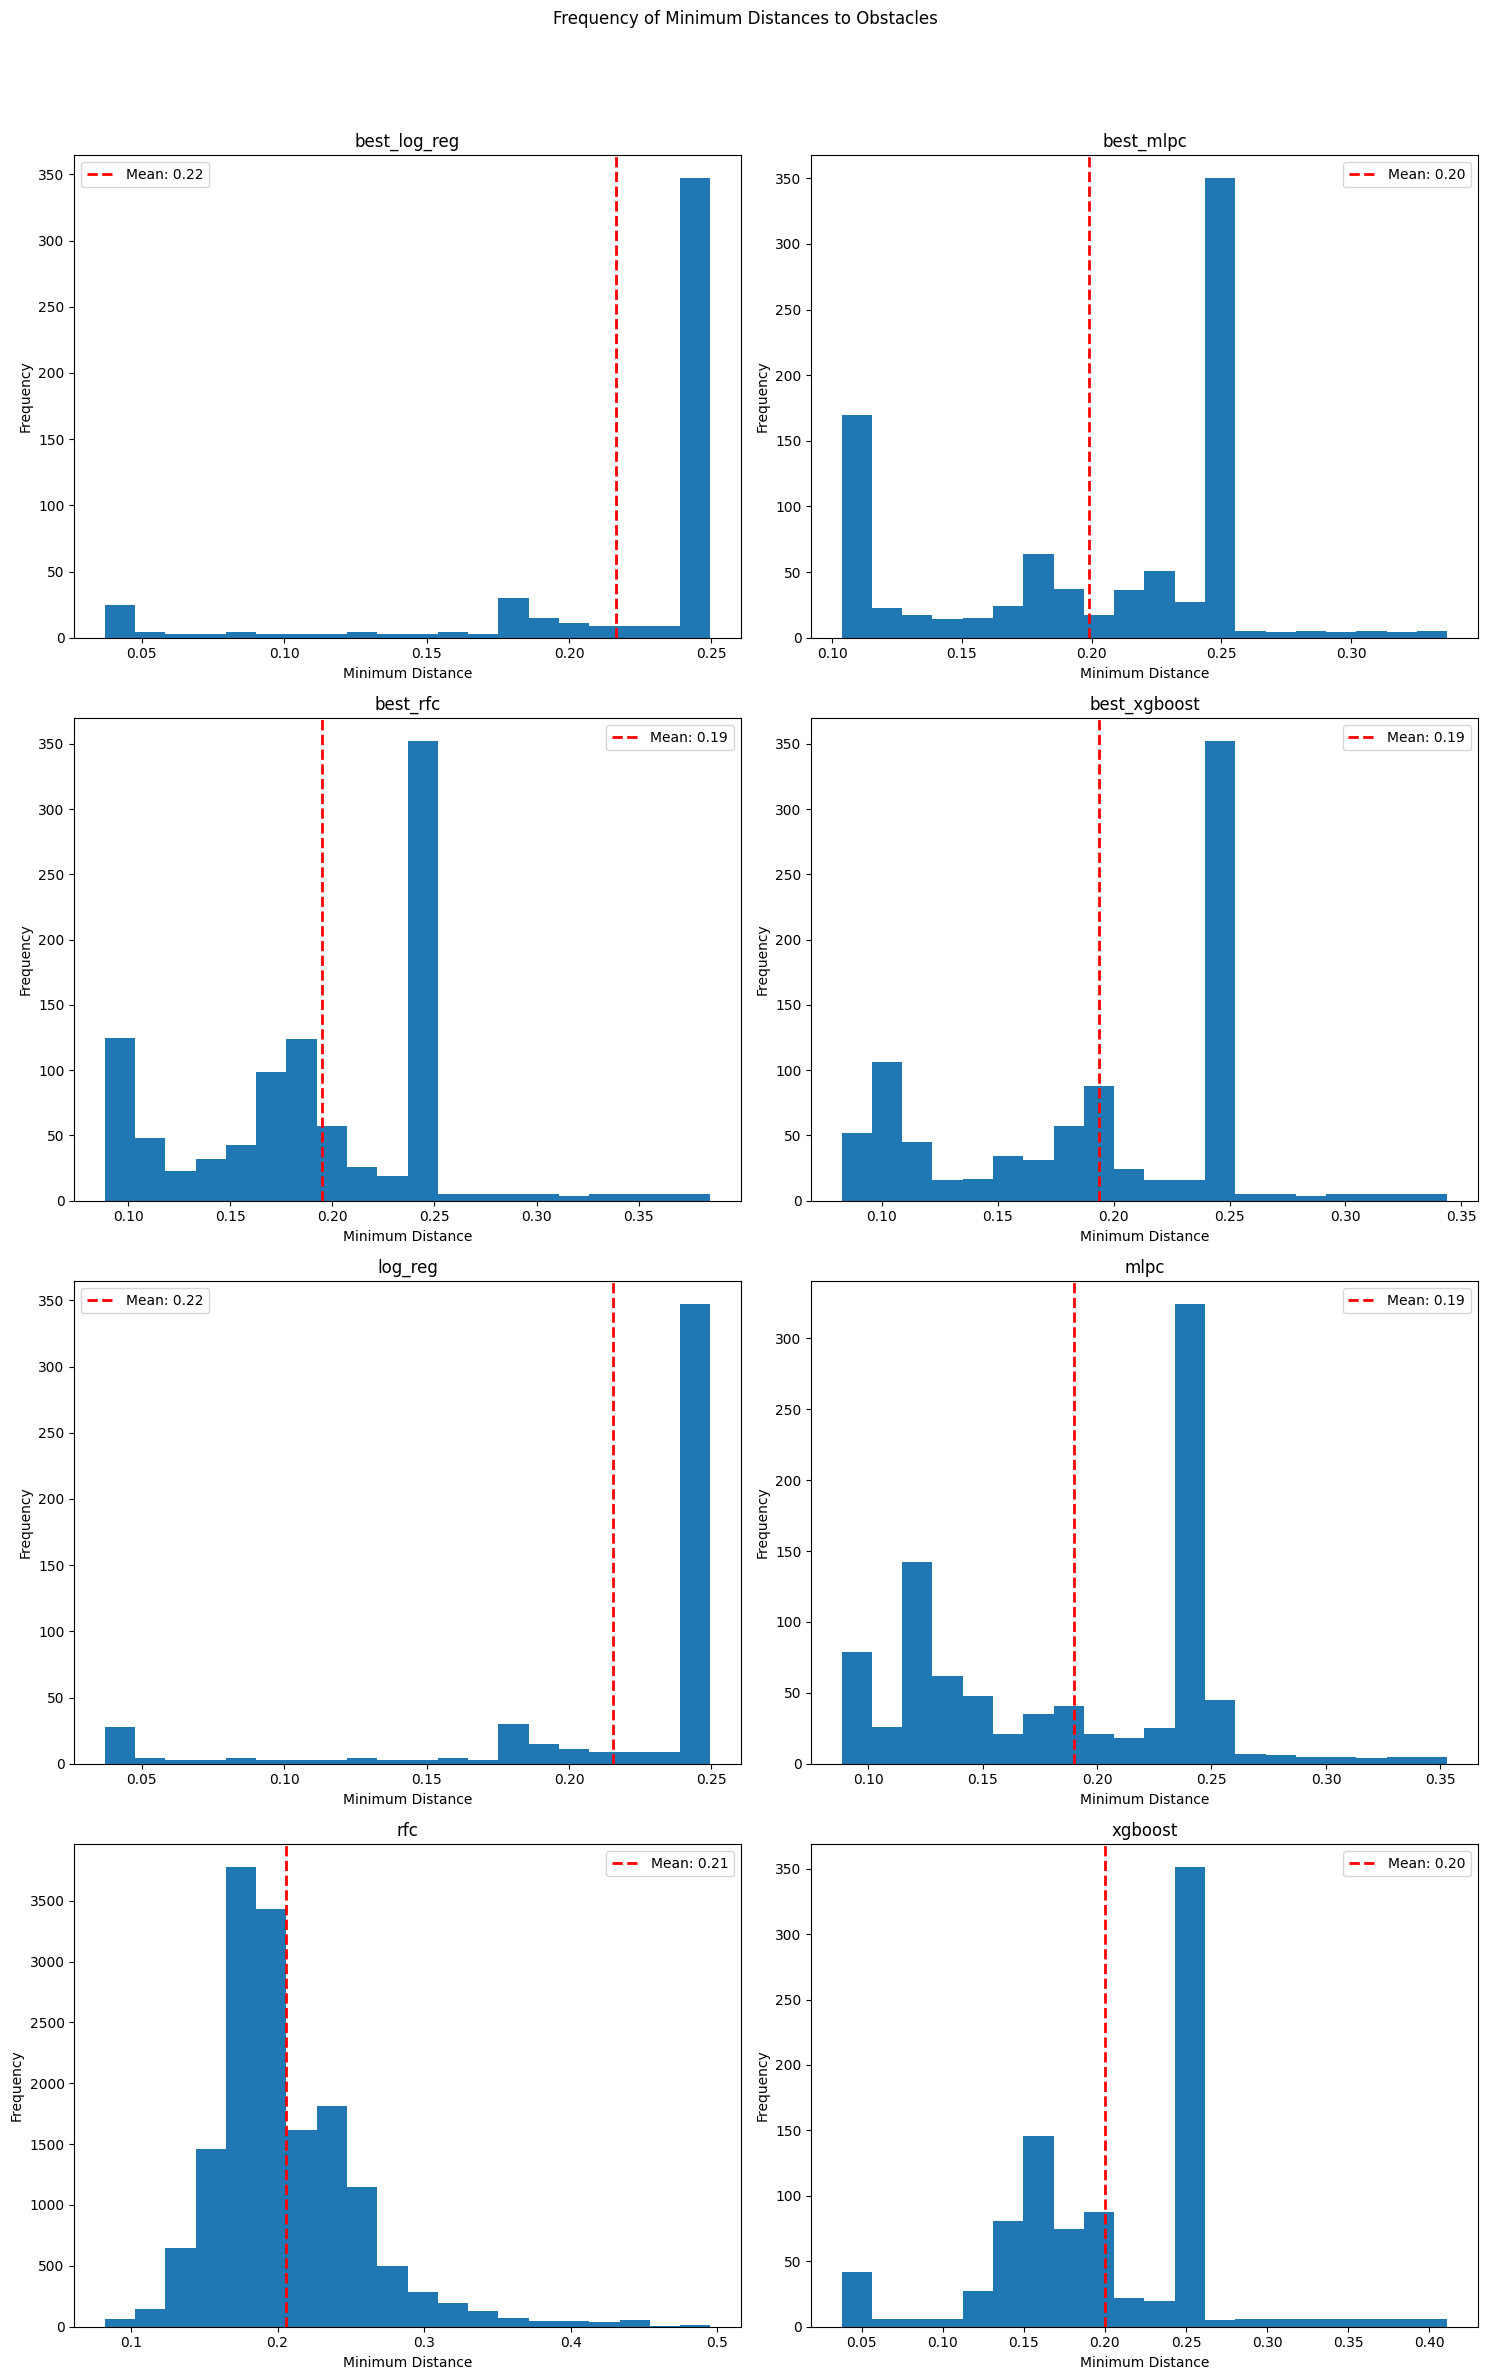

In [2]:
import matplotlib.pyplot as plt

data_folder = "../data/testing/env2"

# create a custom layout with two rows and four columns
fig, axs = plt.subplots(4, 2, figsize=(15, 25))
fig.suptitle('Frequency of Minimum Distances to Obstacles')

# list of model names
model_names = []

for filename in os.listdir(data_folder):
    if filename.endswith('model1_env2.csv'):
        # extract the model name from the filename
        model_name = filename.replace("lidar_data_", "").replace("_model1_env2.csv", "")
        model_names.append(model_name)

# iterate through subplots and models
for ax, model_name in zip(axs.flat, model_names):
    # load the lidar data specific to the model
    model_data = pd.read_csv(os.path.join(data_folder, f"lidar_data_{model_name}_model1_env2.csv"))

    # calculate the minimum distance for each row
    min_distances = model_data.iloc[:, 1:].min(axis=1) # exclude the 'Predicted Action' column

    # calculate the mean of minimum distances
    mean_distance = min_distances.mean()
    
    # plot a histogram of the minimum distances in the current subplot
    ax.hist(min_distances, bins=20)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Frequency')

    # add a vertical line for the mean distance in a different colour
    ax.axvline(mean_distance, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f}')
    ax.legend()

# layout spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### Test environment 2 - Logistic Regression model; simulated for 3.265 minutes

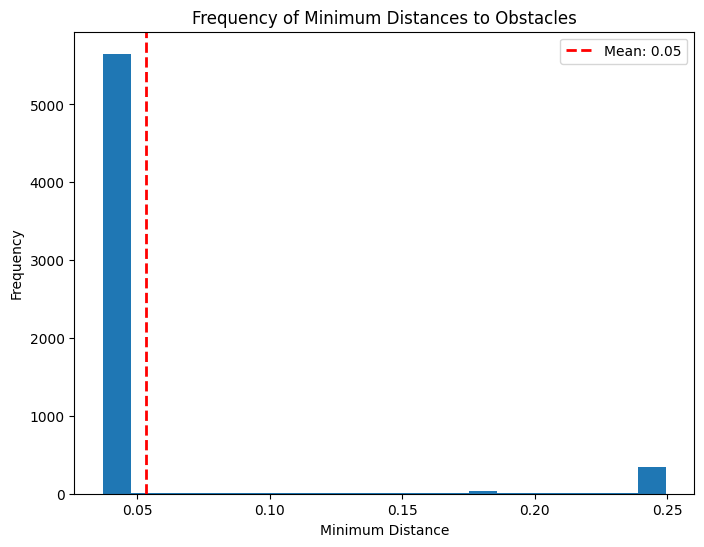

In [3]:
# path to the CSV file to plot
csv_file = "../data/testing/env2/lidar_data_log_reg_model2_env2.csv"

# load the data from the CSV file
model_data = pd.read_csv(csv_file)

# calculate the minimum distance for each row
min_distances = model_data.iloc[:, 1:].min(axis=1) # exclude the 'Predicted Action' column

# calculate the mean of minimum distances
mean_distance = min_distances.mean()

# create a single subplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Frequency of Minimum Distances to Obstacles')
ax.set_xlabel('Minimum Distance')
ax.set_ylabel('Frequency')

# plot a histogram of the minimum distances
ax.hist(min_distances, bins=20)

# add a vertical line for the mean distance in a different colour
ax.axvline(mean_distance, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f}')
ax.legend()

# show the plot
plt.show()

##### Test environment 1

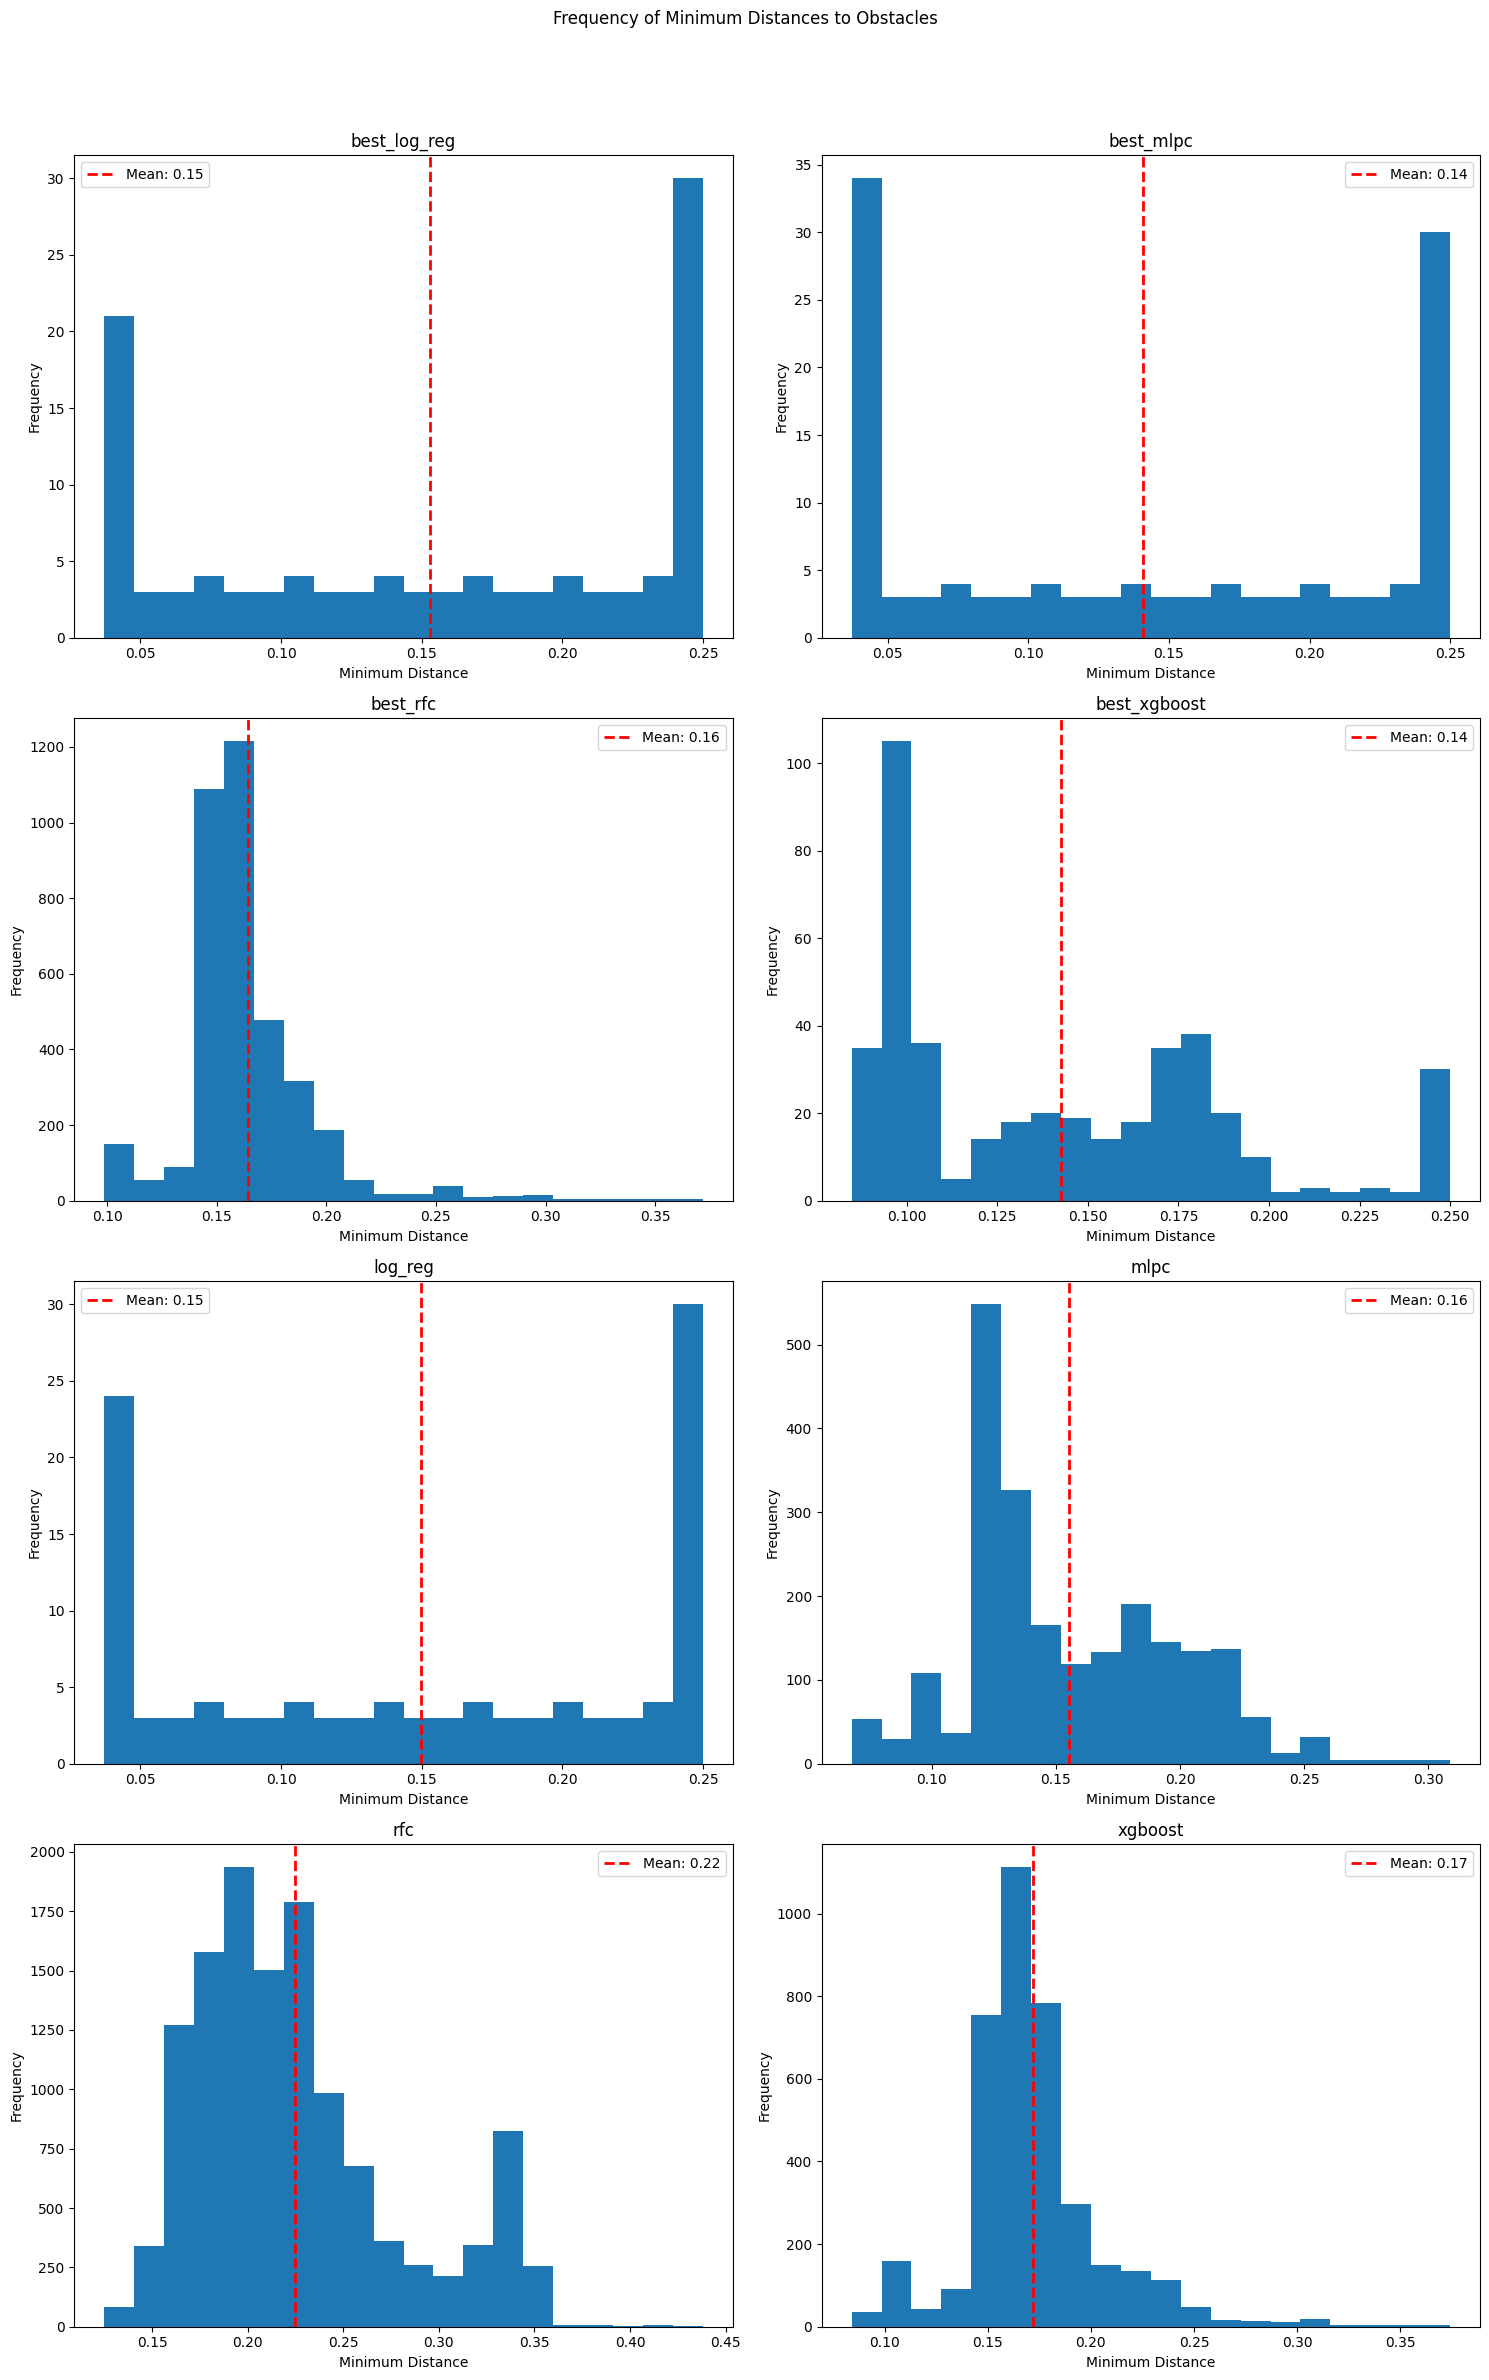

In [4]:
data_folder = "../data/testing/env1"

# create a custom layout with two rows and four columns
fig, axs = plt.subplots(4, 2, figsize=(15, 25))
fig.suptitle('Frequency of Minimum Distances to Obstacles')

# list of model names
model_names = []

for filename in os.listdir(data_folder):
    if filename.endswith('model1_env1.csv'):
        # extract the model name from the filename
        model_name = filename.replace("lidar_data_", "").replace("_model1_env1.csv", "")
        model_names.append(model_name)

# iterate through subplots and models
for ax, model_name in zip(axs.flat, model_names):
    # load the lidar data specific to the model
    model_data = pd.read_csv(os.path.join(data_folder, f"lidar_data_{model_name}_model1_env1.csv"))

    # calculate the minimum distance for each row
    min_distances = model_data.iloc[:, 1:].min(axis=1) # exclude the 'Predicted Action' column
    
    # calculate the mean of minimum distances
    mean_distance = min_distances.mean()
    
    # plot a histogram of the minimum distances in the current subplot
    ax.hist(min_distances, bins=20)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Frequency')

    # add a vertical line for the mean distance in a different colour
    ax.axvline(mean_distance, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f}')
    ax.legend()

# layout spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In 'test environment 2', all models were effective at maintaining a distance of approximately 0.2 units from the obstacle (i.e. wall), this slight variation between all other models (besides Random Forest Classifier) could be due to the amount of data collected and/or how long the robot was left to run when it was stuck. But also, keep in mind that Random Forest Classifier (37,426 KB) had significantly more data (as it did not get stuck unlike the other models), for example it has about 31 times more data than Logistic Regression (1206 KB).

In addition, another plot depicting the Logistic Regression model separately for 'test environment 2' simulates the robot for 195.904 seconds (3.265 minutes) as opposed to the 15.936 seconds (seen in the first set of subplots). After approximately 15.936 seconds, the robot had reached the wall and did not appear to make any progress so the simulation was stopped, but when we do not stop the simulation and allow it to run for a longer duration (when the robot is just driving into the wall) we notice that the minimum distance changes significantly. In other words, the first set of subplots show a slight variation due to the fact the some of the simulations may have been run slightly longer (when driving into a wall) to see if there was a possibility of it progressing in the course.

In 'test environment 1', we now notice that the random forest classifier was consistently better at maintaining an sufficient distance from an obstacle, this in turn helped it to be more successful at avoidance, thereby allowing it to travel further (e.g. more distance to perform the turns and make more appropriate decisions). As well as, was much better as separating the 'classes' to make more refined decisions.

#### Decision-making (input versus action)

##### Training data (input)

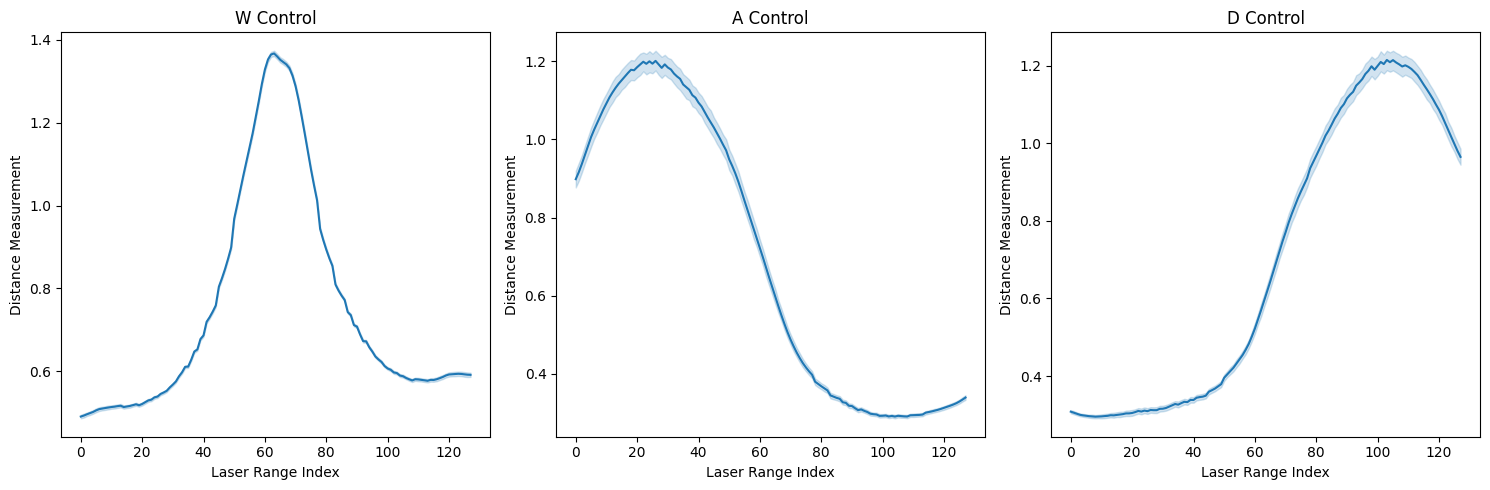

In [5]:
import seaborn as sns
import numpy as np

# load the data used for training the models
csv_combined_df = pd.read_csv("../data/model/lidar_data_combined.csv")

# convert ASCII code values into corresponding characters
csv_combined_df['Keyboard Input'] = csv_combined_df['Keyboard Input'].apply(lambda x: chr(int(x)))
csv_combined_df['Keyboard Input'].value_counts()

# define control options
control_options = ['W', 'A', 'D']

# create a custom layout with a single row and three columns
fig, axs = plt.subplots(1, len(control_options), figsize=(15, 5))

for i, control_option in enumerate(control_options):
    # separate dataframes for each keyboard control option
    df_control = csv_combined_df[csv_combined_df['Keyboard Input'] == control_option]
    
    # calculate the corresponding x and y data
    X_control = np.matmul(np.ones((df_control.shape[0], 1)), np.arange(128).reshape(1, -1))
    Y_control = df_control.iloc[:, 1:].values
    x_control = X_control.flatten()
    y_control = Y_control.flatten()

    # create the subplots
    ax_control = sns.lineplot(x=x_control, y=y_control, ax=axs[i])
    ax_control.set_title(f'{control_option} Control')
    ax_control.set_xlabel('Laser Range Index')
    ax_control.set_ylabel('Distance Measurement')

# adjust the layout for better spacing
plt.tight_layout()
plt.show()

##### Testing data (action) - test environment 2

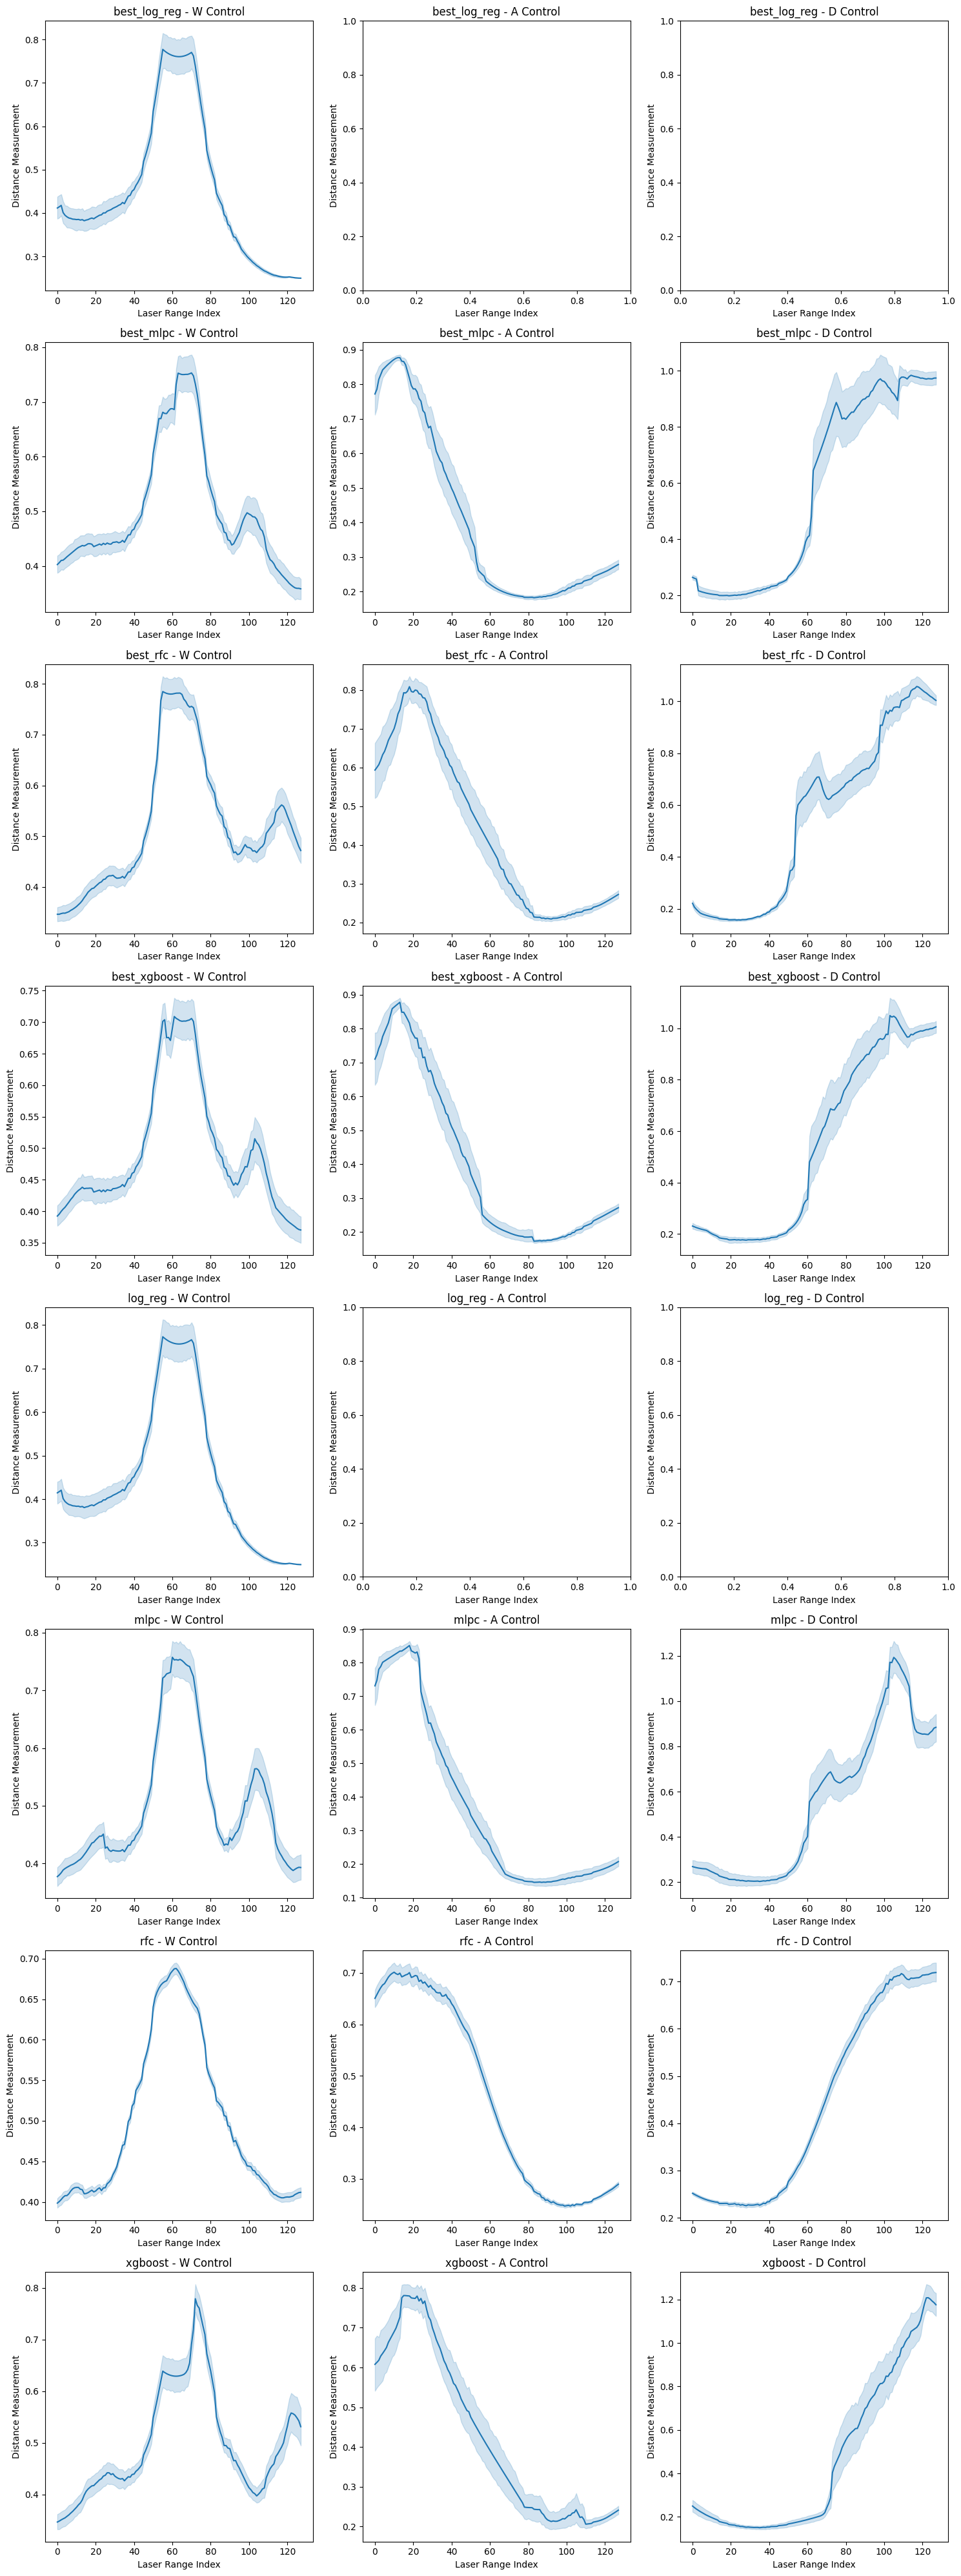

In [6]:
# define the directory where the CSV files are located
data_folder = "../data/testing/env2"

# list of model names
model_names = []

for filename in os.listdir(data_folder):
    if filename.endswith('model1_env2.csv'):
        # extract the model name from the filename
        name = filename.replace("lidar_data_", "").replace("_model1_env2.csv", "")
        model_names.append(name)

# create a custom layout based on number of models
num_rows = len(model_names)
fig, axs = plt.subplots(num_rows, len(control_options), figsize=(15, 5 * num_rows))

# map the XGBoost integer values (0,1,2) to input values corresponding to the ASCII code
int_to_input = {
    0: 65,  # 'A'
    1: 68,  # 'D'
    2: 87,  # 'W'
}

for row, model_name in enumerate(model_names):
    # load the specific CSV file for the current model
    csv_data = pd.read_csv(os.path.join(data_folder, f"lidar_data_{model_name}_model1_env2.csv"))
    
    # check if the model_name contains 'xgboost' or 'best_xgboost'
    if 'xgboost' in model_name or 'best_xgboost' in model_name:
        # map "Predicted Action" to corresponding ASCII code values using int_to_input
        csv_data['Predicted Action'] = csv_data['Predicted Action'].map(int_to_input)

    # convert ASCII code values into corresponding characters
    csv_data['Predicted Action'] = csv_data['Predicted Action'].apply(lambda x: chr(int(x)))
        
    # iterate through control options
    for col, control_option in enumerate(control_options):
        # separate dataframes for each keyboard control option
        df_control = csv_data[csv_data['Predicted Action'] == control_option]

        # calculate the corresponding x and y data
        X_control = np.matmul(np.ones((df_control.shape[0], 1)), np.arange(128).reshape(1, -1))
        Y_control = df_control.iloc[:, 1:].values
        x_control = X_control.flatten()
        y_control = Y_control.flatten()

        # create the subplots
        ax_control = sns.lineplot(x=x_control, y=y_control, ax=axs[row, col])
        ax_control.set_title(f'{model_name} - {control_option} Control')
        ax_control.set_xlabel('Laser Range Index')
        ax_control.set_ylabel('Distance Measurement')

# adjust the layout for better spacing
plt.tight_layout()
plt.show()

##### Testing data (action) - test environment 1

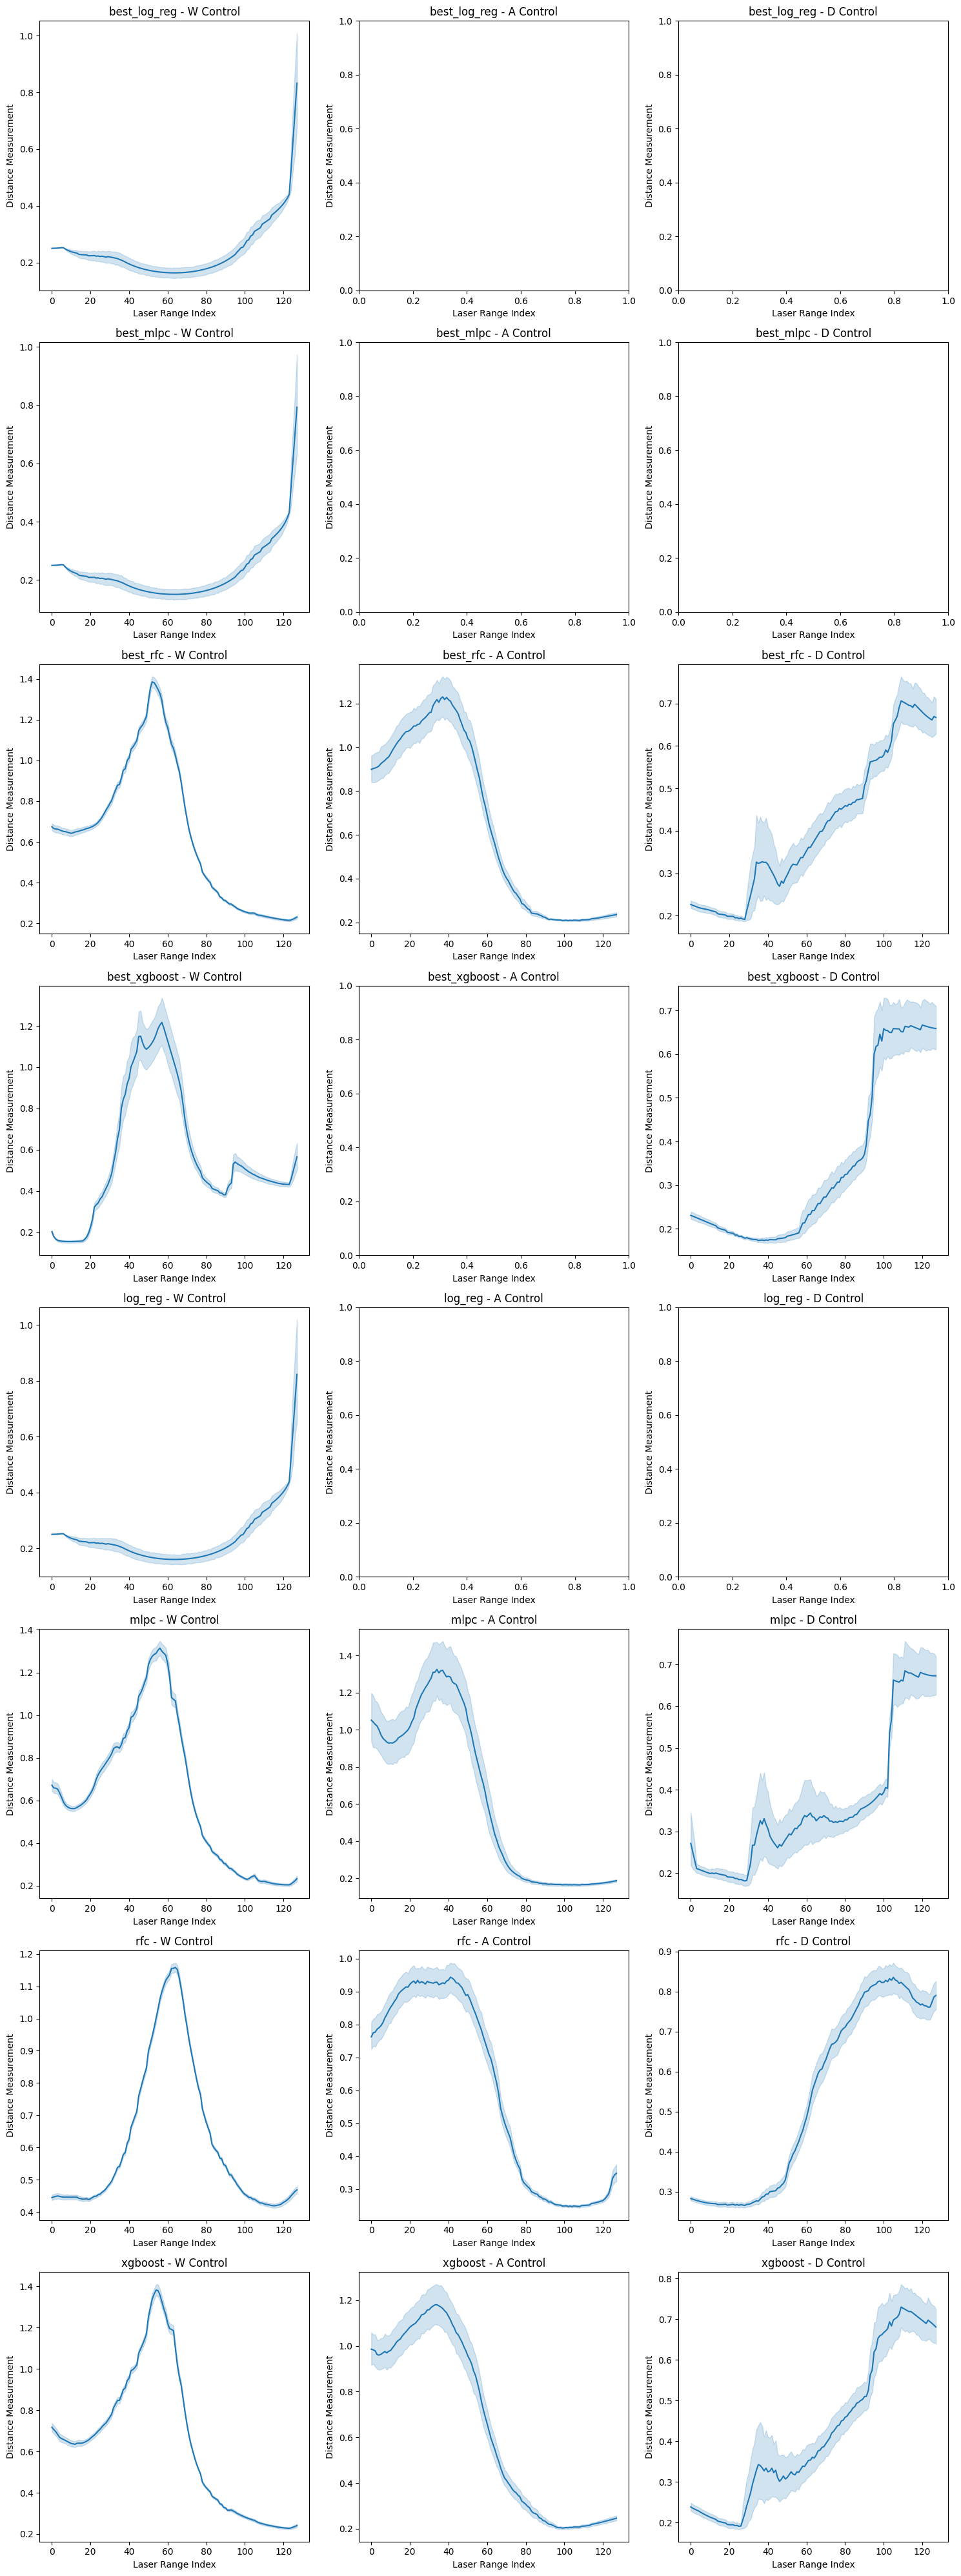

In [7]:
# define the directory where the CSV files are located
data_folder = "../data/testing/env1"

# list of model names
model_names = []

for filename in os.listdir(data_folder):
    if filename.endswith('model1_env1.csv'):
        # extract the model name from the filename
        name = filename.replace("lidar_data_", "").replace("_model1_env1.csv", "")
        model_names.append(name)

# create a custom layout based on number of models
num_rows = len(model_names)
fig, axs = plt.subplots(num_rows, len(control_options), figsize=(15, 5 * num_rows))

# map the XGBoost integer values (0,1,2) to input values corresponding to the ASCII code
int_to_input = {
    0: 65,  # 'A'
    1: 68,  # 'D'
    2: 87,  # 'W'
}

for row, model_name in enumerate(model_names):
    # load the specific CSV file for the current model
    csv_data = pd.read_csv(os.path.join(data_folder, f"lidar_data_{model_name}_model1_env1.csv"))
    
    # check if the model_name contains 'xgboost' or 'best_xgboost'
    if 'xgboost' in model_name or 'best_xgboost' in model_name:
        # map "Predicted Action" to corresponding ASCII code values using int_to_input
        csv_data['Predicted Action'] = csv_data['Predicted Action'].map(int_to_input)

    # convert ASCII code values into corresponding characters
    csv_data['Predicted Action'] = csv_data['Predicted Action'].apply(lambda x: chr(int(x)))
        
    # iterate through control options
    for col, control_option in enumerate(control_options):
        # separate dataframes for each keyboard control option
        df_control = csv_data[csv_data['Predicted Action'] == control_option]

        # calculate the corresponding x and y data
        X_control = np.matmul(np.ones((df_control.shape[0], 1)), np.arange(128).reshape(1, -1))
        Y_control = df_control.iloc[:, 1:].values
        x_control = X_control.flatten()
        y_control = Y_control.flatten()

        # create the subplots
        ax_control = sns.lineplot(x=x_control, y=y_control, ax=axs[row, col])
        ax_control.set_title(f'{model_name} - {control_option} Control')
        ax_control.set_xlabel('Laser Range Index')
        ax_control.set_ylabel('Distance Measurement')

# adjust the layout for better spacing
plt.tight_layout()
plt.show()